In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from scipy.spatial.distance import euclidean
from scipy.spatial.distance import cityblock
from tslearn.metrics import dtw, dtw_path, cdist_dtw, subsequence_cost_matrix
from scipy.spatial.distance import cdist
from pyts.metrics import dtw as dtw2
import numpy as np
import scipy.stats as stats
from tsfresh.feature_extraction import extract_features
import zlib
import string
from tslearn.piecewise import PiecewiseAggregateApproximation
from tslearn.piecewise import SymbolicAggregateApproximation
from tslearn.piecewise import OneD_SymbolicAggregateApproximation

from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from sklearn.cluster import DBSCAN

def create_time_index(df):
    df = df.reset_index() # con indice numerico possiamo interare lungo il df normalmente
    #create the new index
    time=[]
    for i in df.index:
        h = df.loc[i]['hour']
        m = df.loc[i]['minute']
       
        time.append(str(h) + ":" + str(m))
    #substitute the old index with the new one
    df['time'] = time
    df = df.set_index('time')
    df = df.drop(columns=['date'])
    return df

C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d %H:%M:%S')

df_training = pd.read_csv('training.csv', parse_dates= True, index_col='date', date_parser=dateparse)
df_test = pd.read_csv('test.csv', parse_dates=True, index_col='date', date_parser=dateparse)

df = pd.concat([df_training, df_test], axis = 0)

C:\Users\dalla\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.


In [3]:
df_test

,Unnamed: 0,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,day,hour,minute,day_minute,cumulative_hour,cumulative_minute,weekend
date,,,,,,,,,,,,,,
2015-02-14 02:31:59,14392,19.790,36.290000,0.00,503.500000,0.005185,0,14,2,32,152,276,16573,1
2015-02-14 02:32:59,14393,19.790,36.290000,0.00,507.000000,0.005185,0,14,2,33,153,276,16574,1
2015-02-14 02:34:00,14394,19.790,36.290000,0.00,503.000000,0.005185,0,14,2,34,154,276,16575,1
2015-02-14 02:35:00,14395,19.790,36.290000,0.00,501.000000,0.005185,0,14,2,35,155,276,16576,1
2015-02-14 02:36:00,14396,19.760,36.363333,0.00,503.666667,0.005186,0,14,2,36,156,276,16577,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-02-18 09:15:00,20555,20.815,27.717500,429.75,1505.250000,0.004213,1,18,9,15,555,379,22736,0
2015-02-18 09:16:00,20556,20.865,27.745000,423.50,1514.500000,0.004230,1,18,9,16,556,379,22737,0
2015-02-18 09:16:59,20557,20.890,27.745000,423.50,1521.500000,0.004237,1,18,9,17,557,379,22738,0


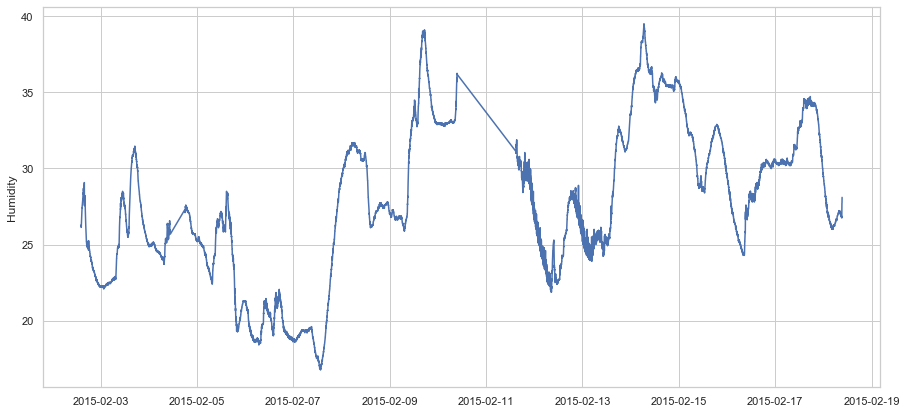

date
2015-02-02 14:19:00    26.2720
2015-02-02 14:19:59    26.2900
2015-02-02 14:21:00    26.2300
2015-02-02 14:22:00    26.1250
2015-02-02 14:23:00    26.2000
                        ...   
2015-02-18 09:15:00    27.7175
2015-02-18 09:16:00    27.7450
2015-02-18 09:16:59    27.7450
2015-02-18 09:17:59    28.0225
2015-02-18 09:19:00    28.1000
Name: Humidity, Length: 20560, dtype: float64

In [4]:
plt.figure(figsize=(15,7))
sns.set(style='whitegrid')
ts = df['Humidity']
plt.ylabel('Humidity')
plt.grid(True)
plt.plot(ts)
plt.show()
ts

# Create the new times series

Vengono estratte 12 time series di durata 24 ore, che corrispondono ai giorni nel dataset che hanno una copertura di dati completa

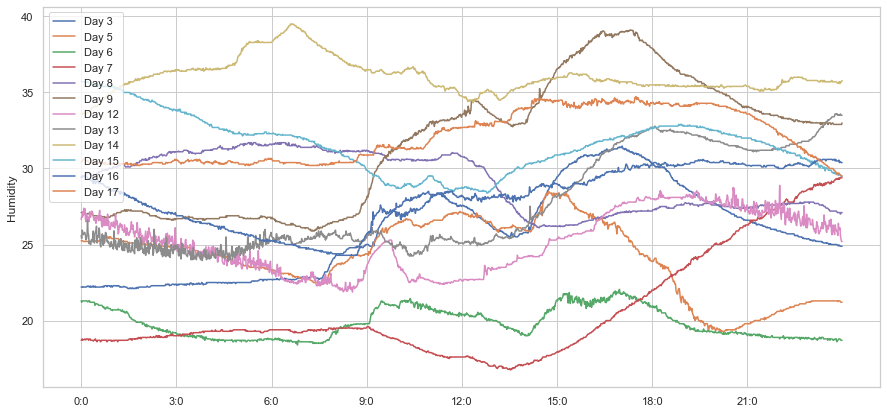

In [5]:
ts3 = df.loc[df['day'] == 3] #martedì 4 febbraio
ts5 = df.loc[df['day'] == 5] #giovedì 5 febbraio
ts6 = df.loc[df['day'] == 6] # ...
ts7 = df.loc[df['day'] == 7] #weekend
ts8 = df.loc[df['day'] == 8] #weekend
ts9 = df.loc[df['day'] == 9] # primo salto temporale (interruzione delle registrazioni nei giorni 10 e 11)
ts12 = df.loc[df['day'] == 12]
ts13 = df.loc[df['day'] == 13]
ts14 = df.loc[df['day'] == 14] #weekend
ts15 = df.loc[df['day'] == 15] #weekend
ts16 = df.loc[df['day'] == 16]
ts17 = df.loc[df['day'] == 17]


ts3 = create_time_index(ts3)
ts5 = create_time_index(ts5)
ts6 = create_time_index(ts6)
ts7 = create_time_index(ts7)
ts8 = create_time_index(ts8)
ts9 = create_time_index(ts9)
ts12 = create_time_index(ts12)
ts13 = create_time_index(ts13)
ts14 = create_time_index(ts14)
ts15 = create_time_index(ts15)
ts16 = create_time_index(ts16)
ts17 = create_time_index(ts17)

plt.figure(figsize=(15,7))
ts3 = ts3['Humidity']
ts5 = ts5['Humidity']
ts6 = ts6['Humidity']
ts7 = ts7['Humidity']
ts8 = ts8['Humidity']
ts9 = ts9['Humidity']
ts12 = ts12['Humidity']
ts13 = ts13['Humidity']
ts14 = ts14['Humidity']
ts15 = ts15['Humidity']
ts16 = ts16['Humidity']
ts17 = ts17['Humidity']


sns.set(style = 'whitegrid')
plt.ylabel('Humidity')
plt.plot(ts3)
plt.plot(ts5)
plt.plot(ts6)
plt.plot(ts7)
plt.plot(ts8)
plt.plot(ts9)
plt.plot(ts12)
plt.plot(ts13)
plt.plot(ts14)
plt.plot(ts15)
plt.plot(ts16)
plt.plot(ts17)
plt.legend(["Day 3", 'Day 5', 'Day 6', 'Day 7', 'Day 8', 'Day 9', 'Day 12', 'Day 13', 'Day 14', 'Day 15', 'Day 16', 'Day 17'])
plt.xticks(range(0, 1440, 180))
plt.show()

In [6]:
ts3

time
0:0      22.20
0:1      22.20
0:2      22.20
0:3      22.23
0:4      22.20
         ...  
23:55    24.89
23:56    24.89
23:57    24.89
23:58    24.89
23:59    24.89
Name: Humidity, Length: 1440, dtype: float64

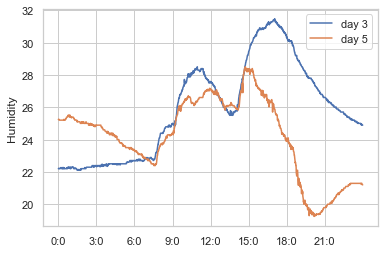

In [7]:
sns.set(style = 'whitegrid')
plt.ylabel('Humidity')
plt.plot(ts3)
plt.plot(ts5)
plt.legend(["day 3", 'day 5'])
plt.xticks(range(0, 1440, 180))
plt.show()

# Transformations

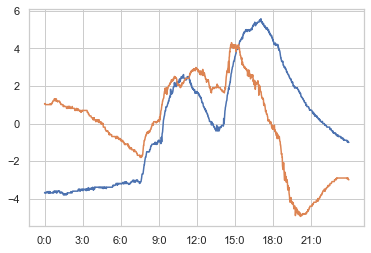

In [8]:
plt.plot(ts3 - ts3.mean())
plt.plot(ts5 - ts5.mean())
plt.xticks(range(0, 1440, 180))
plt.show()

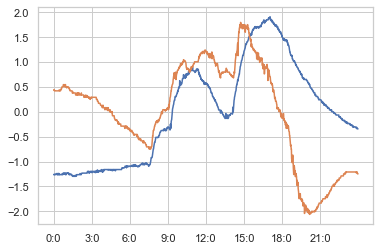

In [9]:
plt.plot((ts3 - ts3.mean())/ts3.std())
plt.plot((ts5 - ts5.mean())/ts5.std())
plt.xticks(range(0, 1440, 180))
plt.show()

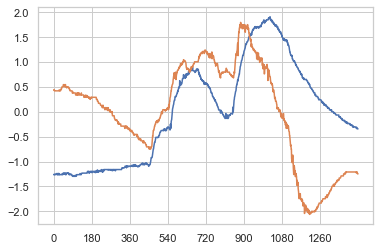

In [10]:
scaler = TimeSeriesScalerMeanVariance(mu=0., std=1.)  # Rescale time series
ts3_scaled = scaler.fit_transform(ts3).flatten()
ts5_scaled = scaler.fit_transform(ts5).flatten()

plt.plot(ts3_scaled)
plt.plot(ts5_scaled)
plt.xticks(range(0, 1440, 180))
plt.show()

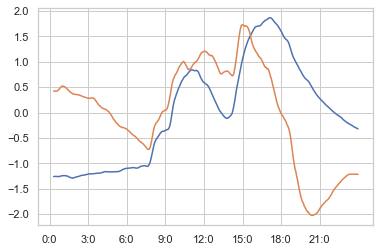

In [11]:
w = 20
plt.plot(((ts3 - ts3.mean())/ts3.std()).rolling(window=w).mean())
plt.plot(((ts5 - ts5.mean())/ts5.std()).rolling(window=w).mean())
plt.xticks(range(0, 1440, 180))
plt.show()

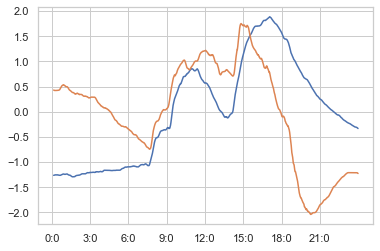

In [12]:
w = 10
plt.plot(((ts3 - ts3.mean())/ts3.std()).rolling(window=w).mean())
plt.plot(((ts5 - ts5.mean())/ts5.std()).rolling(window=w).mean())
plt.xticks(range(0, 1440, 180))

ts3_smooth = ((ts3 - ts3.mean())/ts3.std()).rolling(window=w).mean()
ts5_smooth = ((ts5 - ts5.mean())/ts5.std()).rolling(window=w).mean()
plt.show()

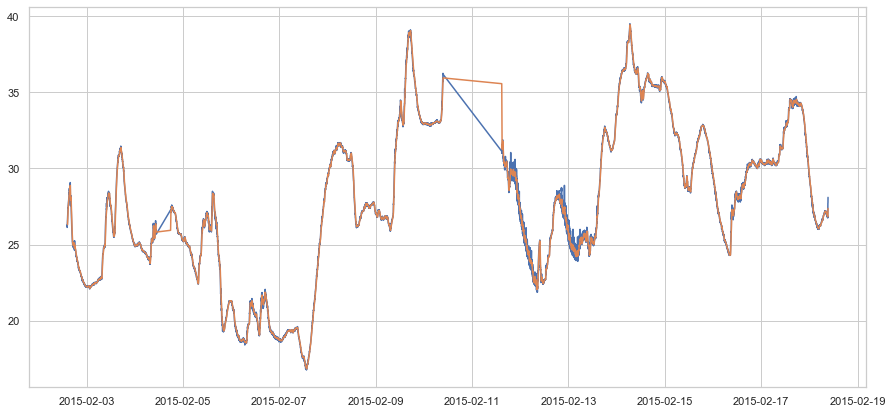

In [13]:
plt.figure(figsize=(15,7))
plt.plot(ts)
plt.plot(ts.rolling(window=12).mean())
plt.show()

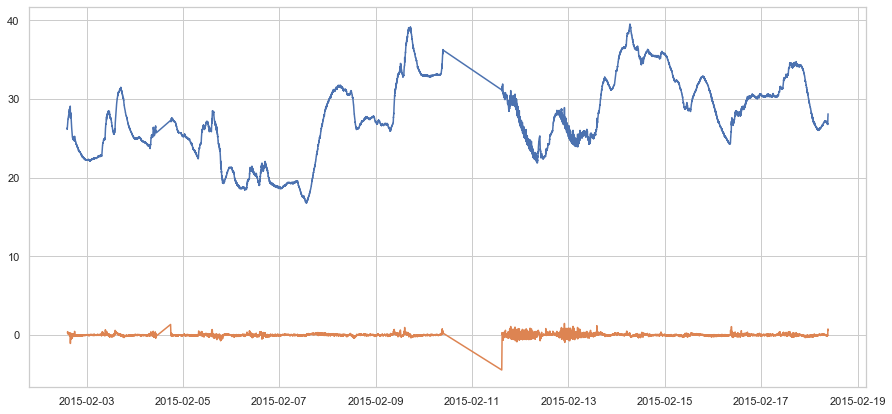

In [14]:
plt.figure(figsize=(15, 7))
plt.plot(ts)
ts_shift = ts - ts.rolling(window=12).mean()
plt.plot(ts_shift)
plt.show()

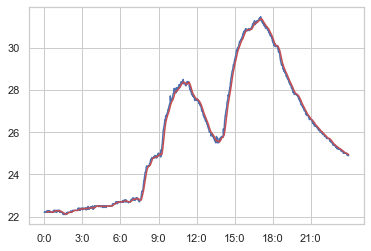

In [15]:
plt.plot(ts3, color = 'b')
plt.plot(ts3.rolling(window=12).mean(), color='r')
plt.xticks(range(0, 1440, 180))
plt.show()

# Distances

## Euclidean distance

In [16]:
#fino a qui nessun cambiamento del formato della ts
ts3

time
0:0      22.20
0:1      22.20
0:2      22.20
0:3      22.23
0:4      22.20
         ...  
23:55    24.89
23:56    24.89
23:57    24.89
23:58    24.89
23:59    24.89
Name: Humidity, Length: 1440, dtype: float64

In [17]:
dist = euclidean(ts3, ts5)
dist

144.23681995165455

In [18]:
ts3_smooth = ts3_smooth[9:]
ts5_smooth = ts5_smooth[9:]
euclidean(ts3_smooth[9:], ts5_smooth[9:])

47.715270724799716

In [19]:
dist = cityblock(ts3, ts5)
dist

4163.244321428572

In [20]:
dist = cityblock(ts3_smooth, ts5_smooth)
dist

1557.1846632279207

## DTW

In [21]:
path, dist = dtw_path(ts3, ts5)

In [22]:
path

[(0, 0),
 (1, 1),
 (2, 2),
 (3, 3),
 (4, 4),
 (5, 5),
 (6, 6),
 (7, 7),
 (8, 8),
 (9, 9),
 (10, 10),
 (11, 11),
 (12, 12),
 (13, 13),
 (14, 14),
 (15, 15),
 (16, 16),
 (17, 17),
 (18, 18),
 (19, 19),
 (20, 20),
 (21, 21),
 (22, 22),
 (23, 23),
 (24, 24),
 (25, 25),
 (26, 26),
 (27, 27),
 (28, 28),
 (29, 29),
 (30, 30),
 (31, 31),
 (32, 32),
 (33, 33),
 (34, 34),
 (35, 35),
 (36, 36),
 (37, 37),
 (38, 38),
 (39, 39),
 (40, 40),
 (41, 41),
 (42, 42),
 (43, 43),
 (44, 44),
 (45, 45),
 (46, 46),
 (47, 47),
 (48, 48),
 (49, 49),
 (50, 50),
 (51, 51),
 (52, 52),
 (53, 53),
 (54, 54),
 (55, 55),
 (56, 56),
 (57, 57),
 (58, 58),
 (59, 59),
 (60, 60),
 (61, 61),
 (62, 62),
 (63, 63),
 (64, 64),
 (65, 65),
 (66, 66),
 (67, 67),
 (68, 68),
 (69, 69),
 (70, 70),
 (71, 71),
 (72, 72),
 (73, 73),
 (74, 74),
 (75, 75),
 (76, 76),
 (77, 77),
 (78, 78),
 (79, 79),
 (80, 80),
 (81, 81),
 (82, 82),
 (83, 83),
 (84, 84),
 (85, 85),
 (86, 86),
 (87, 87),
 (88, 88),
 (89, 89),
 (90, 90),
 (91, 91),
 (92, 92

In [23]:
dist

98.60699551857753

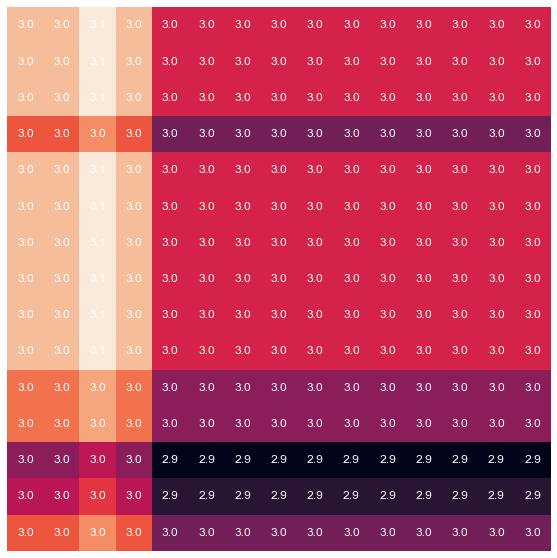

In [24]:
mat = cdist(ts3.values[:15].reshape(-1,1), ts5.values[:15].reshape(-1,1))

plt.figure(figsize=(10, 10))
plt.imshow(mat)
plt.axis("off")
plt.autoscale(False)
for i in range(mat.shape[0]):
    for j in range(mat.shape[1]):
        text = plt.text(j, i, '%.1f' % mat[i, j], ha="center", va="center", color="w")
        
plt.show()

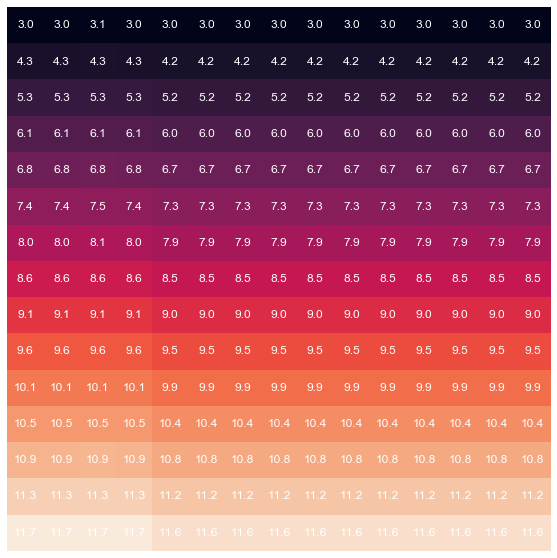

In [25]:
acc = subsequence_cost_matrix(ts3.values[:15].reshape(-1,1), ts5.values[:15].reshape(-1,1))

plt.figure(figsize=(10, 10))
plt.imshow(acc)
plt.axis("off")
plt.autoscale(False)
for i in range(acc.shape[0]):
    for j in range(acc.shape[1]):
        text = plt.text(j, i, '%.1f' % np.sqrt(acc[i, j]), ha="center", va="center", color="w")
        
plt.show()

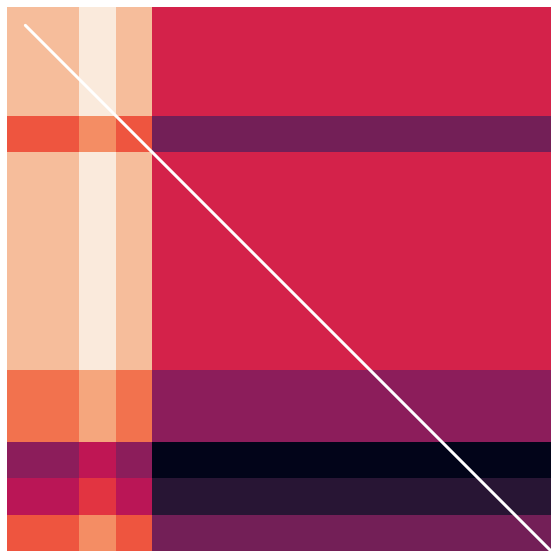

In [26]:
plt.figure(figsize=(10, 10))
plt.imshow(mat)
plt.axis("off")
plt.autoscale(False)
plt.plot([j for (i, j) in path], [i for (i, j) in path], "w-", linewidth=3.)
plt.show()

In [27]:
path, dist = dtw_path(ts3[:15], ts5[:15], global_constraint="sakoe_chiba", sakoe_chiba_radius=5)
dist

11.611557163016508

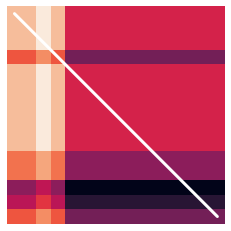

In [28]:
plt.imshow(mat)
plt.axis("off")
plt.autoscale(False)
plt.plot([j for (i, j) in path], [i for (i, j) in path], "w-", linewidth=3.)
plt.show()

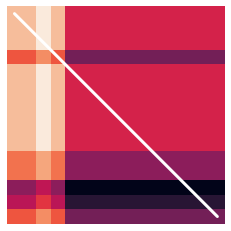

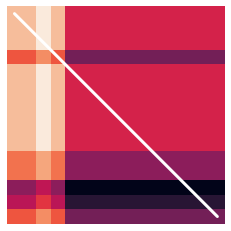

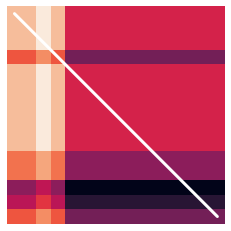

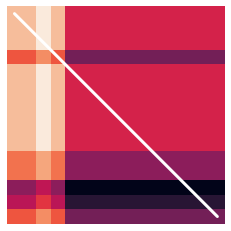

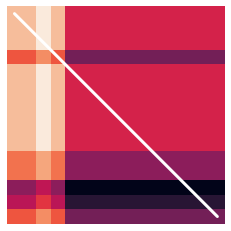

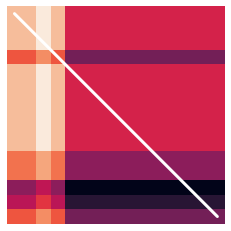

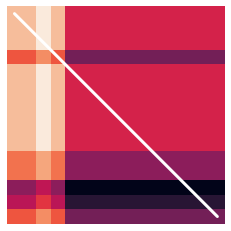

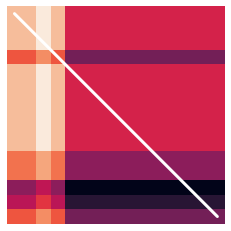

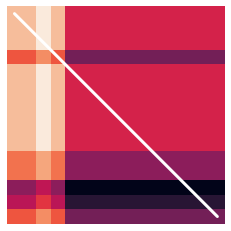

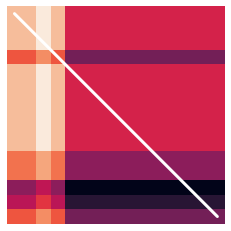

In [29]:
for i in range(1, 11):
    path, dist = dtw_path(ts3[:15], ts5[:15], global_constraint="sakoe_chiba", sakoe_chiba_radius=i)
    plt.imshow(mat)
    plt.axis("off")
    plt.autoscale(False)
    plt.plot([j for (i, j) in path], [i for (i, j) in path], "w-", linewidth=3.)
    plt.show()

In [30]:
path, dist = dtw_path(ts3[:15], ts5[:15], global_constraint="itakura", itakura_max_slope=6.)
dist

11.611557163016508

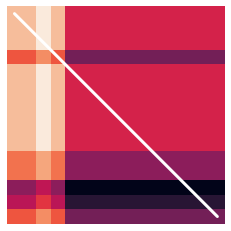

In [31]:
plt.imshow(mat)
plt.axis("off")
plt.autoscale(False)
plt.plot([j for (i, j) in path], [i for (i, j) in path], "w-", linewidth=3.)
plt.show()

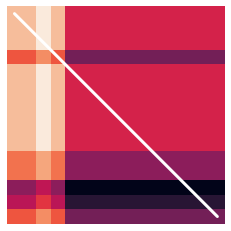

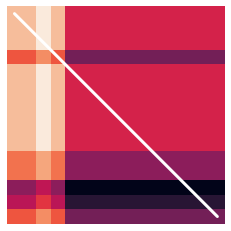

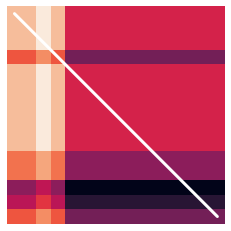

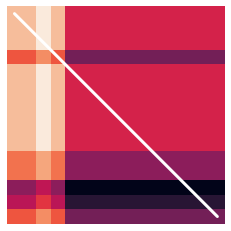

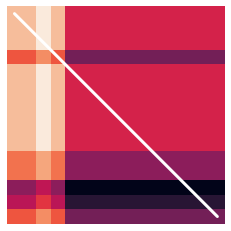

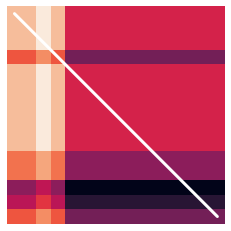

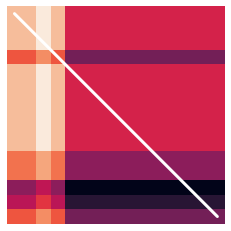

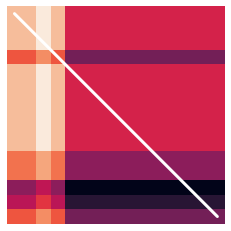

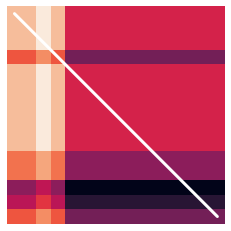

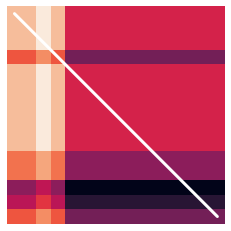

In [32]:
for i in range(1, 11):
    path, dist = dtw_path(ts3[:15], ts5[:15], global_constraint="itakura", itakura_max_slope=i)
    plt.imshow(mat)
    plt.axis("off")
    plt.autoscale(False)
    plt.plot([j for (i, j) in path], [i for (i, j) in path], "w-", linewidth=3.)
    plt.show()

In [33]:
dtw2(ts3.ravel(), ts5.ravel())

98.60699551857753

In [34]:
%%time
dtw2(ts3.ravel(), ts5.ravel(), dist='absolute')

Wall time: 702 ms


2962.185130952368

In [35]:
dtw2(ts3.ravel(), ts5.ravel(), dist='square', method='fast')

144.23681995165472

In [36]:
%%time
dtw2(ts3.ravel(), ts5.ravel(), dist='absolute', method='fast')

Wall time: 662 ms


4163.244321428567

## Features extraction

In [37]:
def calculate_features(values):
    features = {
        'avg': np.mean(values),
        'std': np.std(values),
        'var': np.var(values),
        'med': np.median(values),
        '10p': np.percentile(values, 10),
        '25p': np.percentile(values, 25),
        '50p': np.percentile(values, 50),
        '75p': np.percentile(values, 75),
        '90p': np.percentile(values, 90),
        'iqr': np.percentile(values, 75) - np.percentile(values, 25),
        'cov': 1.0 * np.mean(values) / np.std(values),
        'skw': stats.skew(values),
        'kur': stats.kurtosis(values)
    }

    return features

In [38]:
features = calculate_features(ts)

In [39]:
features

{'avg': 27.655924792710135,
 'std': 4.982032485153784,
 'var': 24.820647683127586,
 'med': 27.29,
 '10p': 20.24725,
 '25p': 24.5,
 '50p': 27.29,
 '75p': 31.29,
 '90p': 34.4,
 'iqr': 6.789999999999999,
 'cov': 5.551132971357263,
 'skw': -0.01354729174869641,
 'kur': -0.6562061030257724}

In [40]:
print(calculate_features(ts3), end="\n\n")
print(calculate_features(ts5), end="\n\n")
print(calculate_features(ts6), end="\n\n")
print(calculate_features(ts7), end="\n\n")
print(calculate_features(ts8), end="\n\n")
print(calculate_features(ts9), end="\n\n")
print(calculate_features(ts12), end="\n\n")
print(calculate_features(ts13), end="\n\n")
print(calculate_features(ts14), end="\n\n")
print(calculate_features(ts15), end="\n\n")
print(calculate_features(ts16), end="\n\n")
print(calculate_features(ts17), end="\n\n")

{'avg': 25.889319998346586, 'std': 2.9194734352338942, 'var': 8.523325139036395, 'med': 25.79266666666665, '10p': 22.29, '25p': 22.7, '50p': 25.79266666666665, '75p': 28.052500000000002, '90p': 30.406342857142878, 'iqr': 5.352500000000003, 'cov': 8.867804613633163, 'skw': 0.24246069169697507, 'kur': -1.1344754816898661}

{'avg': 24.189297685185153, 'std': 2.396220803402675, 'var': 5.741874138659762, 'med': 24.6, '10p': 20.29, '25p': 22.7, '50p': 24.6, '75p': 26.146250000000002, '90p': 26.91825, 'iqr': 3.4462500000000027, 'cov': 10.09476991888057, 'skw': -0.4613226149527144, 'kur': -0.7618175758306442}

{'avg': 19.838107523148157, 'std': 0.997001973507944, 'var': 0.994012935178735, 'med': 19.6, '10p': 18.7, '25p': 18.89, '50p': 19.6, '75p': 20.761875, '90p': 21.29, 'iqr': 1.8718749999999993, 'cov': 19.897761539375818, 'skw': 0.38155974508481233, 'kur': -1.2659966988936444}

{'avg': 20.639421874999982, 'std': 3.451482539715884, 'var': 11.91273172196361, 'med': 19.29, '10p': 17.6, '25p': 

## Compression based distances

In [41]:
def CDM(x, y):
    return len(zlib.compress(x + y)) / (len(zlib.compress(x)) + len(zlib.compress(y)))

In [42]:
ts3_str = (' '.join([str(v) for v in ts3[:10]])).encode('utf-8')
ts3_str

b'22.2 22.2 22.2 22.23 22.2 22.2 22.2 22.2 22.2 22.2'

In [43]:
ts5_str = (' '.join([str(v) for v in ts5[:10]])).encode('utf-8')
ts5_str

b'25.245 25.245 25.26 25.245 25.2 25.2 25.2 25.2 25.2 25.2'

In [44]:
print("len(ts1_str + ts2_str): ", len(ts3_str + ts5_str))
print("len(compress(ts1_str+ts2_str)): ", len(zlib.compress(ts3_str+ts5_str)))
print("len(compress(ts1_str)): ", len(zlib.compress(ts3_str)))
print("len(compress(ts2_str)): ", len(zlib.compress(ts5_str)))
print("CDM = ", CDM(ts3_str, ts5_str))

len(ts1_str + ts2_str):  106
len(compress(ts1_str+ts2_str)):  34
len(compress(ts1_str)):  20
len(compress(ts2_str)):  22
CDM =  0.8095238095238095


In [45]:
ts3_str = (' '.join([str(v) for v in ts3])).encode('utf-8')
ts5_str = (' '.join([str(v) for v in ts5])).encode('utf-8')

print("len(ts1_str + ts2_str): ", len(ts3_str + ts5_str))
print("len(compress(ts1_str+ts2_str)): ", len(zlib.compress(ts3_str+ts5_str)))
print("len(compress(ts1_str)): ", len(zlib.compress(ts3_str)))
print("len(compress(ts2_str)): ", len(zlib.compress(ts5_str)))
print("CDM = ", CDM(ts3_str, ts5_str))

len(ts1_str + ts2_str):  20370
len(compress(ts1_str+ts2_str)):  3573
len(compress(ts1_str)):  1932
len(compress(ts2_str)):  1678
CDM =  0.9897506925207756


# Approximation

## Cella dove vengono trasformate le time series
le times series in formati deiversi mantengono nomi diversi in modo da poter essere successivamente usate:
- ts#_res = rescaled time series (tipo numpy)
- ts# = time serie con dati non trasformati (tipo pandas)

In [46]:
ts3

time
0:0      22.20
0:1      22.20
0:2      22.20
0:3      22.23
0:4      22.20
         ...  
23:55    24.89
23:56    24.89
23:57    24.89
23:58    24.89
23:59    24.89
Name: Humidity, Length: 1440, dtype: float64

In [47]:
scaler = TimeSeriesScalerMeanVariance(mu=0., std=1.) # Rescale time series
ts3_res = scaler.fit_transform(ts3)
ts5_res = scaler.fit_transform(ts5)
ts6_res = scaler.fit_transform(ts6)
ts7_res = scaler.fit_transform(ts7)
ts8_res = scaler.fit_transform(ts8)
ts9_res = scaler.fit_transform(ts9)
ts12_res = scaler.fit_transform(ts12)
ts13_res = scaler.fit_transform(ts13)
ts14_res = scaler.fit_transform(ts14)
ts15_res = scaler.fit_transform(ts15)
ts16_res = scaler.fit_transform(ts16)
ts17_res = scaler.fit_transform(ts17)

In [48]:
ts3_res

array([[[-1.26369364],
        [-1.26369364],
        [-1.26369364],
        ...,
        [-0.3422946 ],
        [-0.3422946 ],
        [-0.3422946 ]]])

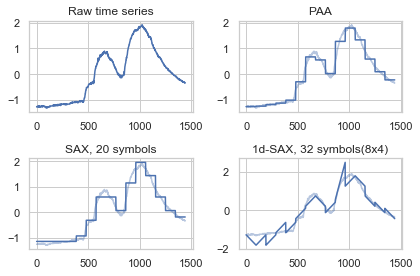

In [49]:
# PAA transform (and inverse transform) of the data

ts = ts3_res # ts era la time series che prendeva le due settimance, per le trasformazioni prendo una ts che dura 1 giorno
n_paa_segments = 15
paa = PiecewiseAggregateApproximation(n_segments=n_paa_segments)
ts_paa = paa.fit_transform(ts)
paa_dataset_inv = paa.inverse_transform(ts_paa)

# SAX transform
n_sax_symbols = 20
sax = SymbolicAggregateApproximation(n_segments=n_paa_segments, alphabet_size_avg=n_sax_symbols)
ts_sax = sax.fit_transform(ts)
sax_dataset_inv = sax.inverse_transform(ts_sax) # inverse_transform trasforma le etichette adattandole al range dei valori nella ts

# 1d-SAX transform
n_sax_symbols_avg = 8
n_sax_symbols_slope = 4
one_d_sax = OneD_SymbolicAggregateApproximation(
    n_segments=n_paa_segments,
    alphabet_size_avg=n_sax_symbols_avg,
    alphabet_size_slope=n_sax_symbols_slope)

ts_sax1d = one_d_sax.fit_transform(ts)
one_d_sax_dataset_inv = one_d_sax.inverse_transform(ts_sax1d)

plt.figure()
plt.subplot(2, 2, 1)  # First, raw time series
plt.plot(ts[0].ravel(), "b-")
plt.title("Raw time series")

plt.subplot(2, 2, 2)  # Second, PAA
plt.plot(ts[0].ravel(), "b-", alpha=0.4)
plt.plot(paa_dataset_inv[0].ravel(), "b-")
plt.title("PAA")

plt.subplot(2, 2, 3)  # Then SAX
plt.plot(ts[0].ravel(), "b-", alpha=0.4)
plt.plot(sax_dataset_inv[0].ravel(), "b-")
plt.title("SAX, %d symbols" % n_sax_symbols)

plt.subplot(2, 2, 4)  # Finally, 1d-SAX
plt.plot(ts[0].ravel(), "b-", alpha=0.4)
plt.plot(one_d_sax_dataset_inv[0].ravel(), "b-")
plt.title("1d-SAX, %d symbols"
          "(%dx%d)" % (n_sax_symbols_avg * n_sax_symbols_slope,
                       n_sax_symbols_avg,
                       n_sax_symbols_slope))

plt.tight_layout()
plt.show()

In [50]:
sax_dataset_inv

array([[[-1.15034938],
        [-1.15034938],
        [-1.15034938],
        ...,
        [-0.18911843],
        [-0.18911843],
        [-0.18911843]]])

In [51]:
ts[0].ravel()

array([-1.26369364, -1.26369364, -1.26369364, ..., -0.3422946 ,
       -0.3422946 , -0.3422946 ])

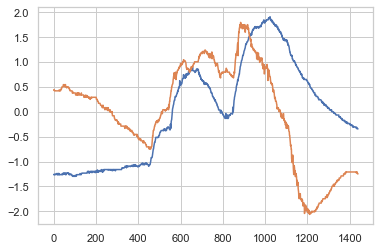

In [52]:
plt.plot(ts3_res[0].ravel())
plt.plot(ts5_res[0].ravel())
plt.show()

In [53]:
ts3_res_paa = paa.fit_transform(ts3_res)
ts5_res_paa = paa.fit_transform(ts5_res)

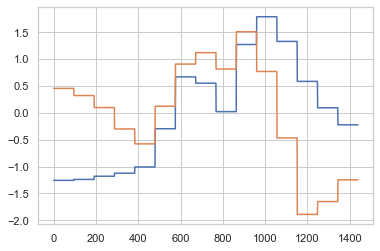

In [54]:
plt.plot(paa.inverse_transform(ts3_res_paa)[0].ravel())
plt.plot(paa.inverse_transform(ts5_res_paa)[0].ravel())
plt.show()

In [55]:
ts3_res_str = (' '.join([str(v) for v in ts3_res_paa[0].ravel()])).encode('utf-8')
ts5_res_str = (' '.join([str(v) for v in ts5_res_paa[0].ravel()])).encode('utf-8')

print("len(ts3_res_str + ts5_res_str): ", len(ts3_res_str + ts5_res_str))
print("len(compress(ts1_str+ts2_str)): ", len(zlib.compress(ts3_res_str+ts5_res_str)))
print("len(compress(ts1_str)): ", len(zlib.compress(ts3_res_str)))
print("len(compress(ts2_str)): ", len(zlib.compress(ts5_res_str)))
print("CDM = ", CDM(ts3_res_str, ts5_res_str))

len(ts3_res_str + ts5_res_str):  587
len(compress(ts1_str+ts2_str)):  302
len(compress(ts1_str)):  166
len(compress(ts2_str)):  165
CDM =  0.9123867069486404


In [56]:
ts3_res_sax = sax.fit_transform(ts3_res)
ts5_res_sax = sax.fit_transform(ts5_res)

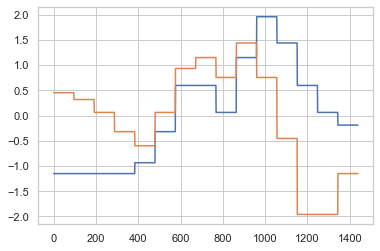

In [57]:
plt.plot(sax.inverse_transform(ts3_res_sax)[0].ravel())
plt.plot(sax.inverse_transform(ts5_res_sax)[0].ravel())
plt.show()

In [58]:
ts3_res_sax1d = one_d_sax.fit_transform(ts3_res)
ts5_res_sax1d = one_d_sax.fit_transform(ts5_res)

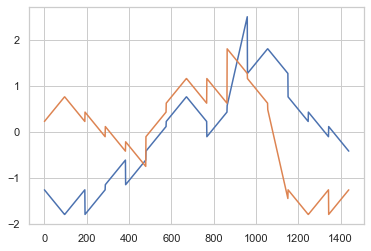

In [59]:
plt.plot(one_d_sax.inverse_transform(ts3_res_sax1d)[0].ravel())
plt.plot(one_d_sax.inverse_transform(ts5_res_sax1d)[0].ravel())
plt.show()

In [60]:
ts3_res_str = (' '.join([str(v) for v in ts3_res_sax1d[0].ravel()])).encode('utf-8')
ts5_res_str = (' '.join([str(v) for v in ts5_res_sax1d[0].ravel()])).encode('utf-8')

print("len(ts3_res_str + ts5_res_str): ", len(ts3_res_str + ts5_res_str))
print("len(compress(ts1_str+ts2_str)): ", len(zlib.compress(ts3_res_str+ts5_res_str)))
print("len(compress(ts3_res_str)): ", len(zlib.compress(ts3_res_str)))
print("len(compress(ts5_res_str)): ", len(zlib.compress(ts5_res_str)))
print("CDM = ", CDM(ts3_res_str, ts5_res_str))

len(ts3_res_str + ts5_res_str):  118
len(compress(ts1_str+ts2_str)):  58
len(compress(ts3_res_str)):  41
len(compress(ts5_res_str)):  43
CDM =  0.6904761904761905


# Data preparation for clustering

Come per le ts sopra, anche per X vengono create due versioni
- X : matrice con le ts senza trasformazione ma con noise reduction
- X_res_nr : matrice con le ts trasformate e noise reduction

In [61]:
# ts3, ts5, .... non sono normalizzate con TimeSeriesScalerMeanVariance perché i risultati sono migliori
# rispetto alla controparte trasformata.
X = np.array([ts3.rolling(window=30).mean(),
              ts5.rolling(window=30).mean(),
              ts6.rolling(window=30).mean(),
              ts7.rolling(window=30).mean(),
              ts8.rolling(window=30).mean(),
              ts9.rolling(window=30).mean(),
              ts12.rolling(window=30).mean(),
              ts13.rolling(window=30).mean(),
              ts14.rolling(window=30).mean(),
              ts15.rolling(window=30).mean(),
              ts16.rolling(window=30).mean(),
              ts17.rolling(window=30).mean(),])

# problema: i primi 19 valori (window -1) contengono 'nan'
X_new = np.empty((12, 1411))
for i in range(len(X)):
    X_new[i] = X[i][29:] #tolgo valori nan con slicing
X = X_new

X.shape

(12, 1411)

In [62]:
# nuova versione di time series e X_res con Noise Reduction
w=30
ts3_res_nr = ((ts3 - ts3.mean())/ts3.std()).rolling(window=w).mean()
ts5_res_nr = ((ts5 - ts5.mean())/ts5.std()).rolling(window=w).mean()
ts6_res_nr = ((ts6 - ts6.mean())/ts6.std()).rolling(window=w).mean()
ts7_res_nr = ((ts7 - ts7.mean())/ts7.std()).rolling(window=w).mean()
ts8_res_nr = ((ts8 - ts8.mean())/ts8.std()).rolling(window=w).mean()
ts9_res_nr = ((ts9 - ts9.mean())/ts9.std()).rolling(window=w).mean()
ts12_res_nr = ((ts12 - ts12.mean())/ts12.std()).rolling(window=w).mean()
ts13_res_nr = ((ts13 - ts13.mean())/ts13.std()).rolling(window=w).mean()
ts14_res_nr = ((ts14 - ts14.mean())/ts14.std()).rolling(window=w).mean()
ts15_res_nr = ((ts15 - ts15.mean())/ts15.std()).rolling(window=w).mean()
ts16_res_nr = ((ts16 - ts16.mean())/ts16.std()).rolling(window=w).mean()
ts17_res_nr = ((ts17 - ts17.mean())/ts17.std()).rolling(window=w).mean()

X_res_nr = np.array([ts3_res_nr,
             ts5_res_nr,
             ts6_res_nr,
             ts7_res_nr,
             ts8_res_nr,
             ts9_res_nr,
             ts12_res_nr,
             ts13_res_nr,
             ts14_res_nr,
             ts15_res_nr,
             ts16_res_nr,
             ts17_res_nr])


# problema: i primi 29 valori (window -1) contengono 'nan'
X_res_nr_new = np.empty((12, 1411))
for i in range(len(X_res_nr)):
    X_res_nr_new[i] = X_res_nr[i][29:] #tolgo valori nan con slicing
X_res_nr = X_res_nr_new

X_res_nr.shape

(12, 1411)

In [63]:
len(X_res_nr)

12

# Clustering

## Clustering con distanza euclidea

- proviamo diverso numero di k (migliore k = 3)
- con dati senza trasformazione (K=2)
- con dati senza trasformazione (K=3)
- con dati trasformati ma vediamo che il cluster sono più disordinati

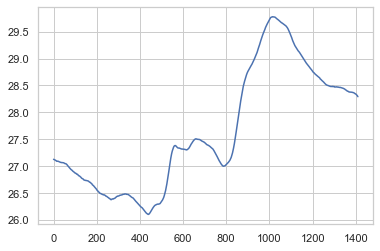

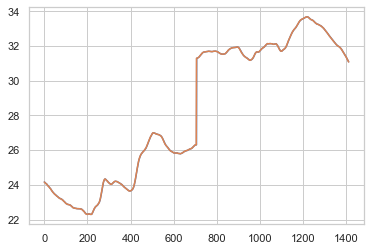

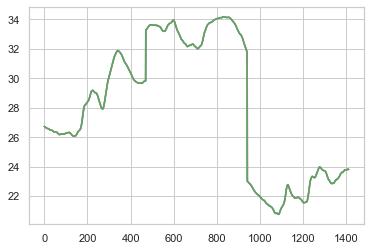

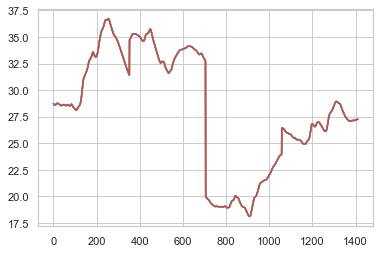

In [64]:
for i in range(1 ,5):
    km = TimeSeriesKMeans(n_clusters=i, metric="euclidean", max_iter=5, random_state=0)
    km.fit(X)
    plt.plot(km.cluster_centers_.reshape(X.shape[1], i))
    plt.show()

In [65]:
km.labels_ # 3 5 6 7 8 9 12 13 14 15 16 17

array([3, 3, 2, 2, 3, 0, 3, 3, 1, 1, 3, 0], dtype=int64)

In [66]:
# DA COPIARE SOTTO, QUANDO CALCOLO LE PAIRWISE DISTANCES PER DBSCAN
X_res = np.array([ts3_res[0].ravel(),
             ts5_res[0].ravel(),
             ts6_res[0].ravel(),
             ts7_res[0].ravel(),
             ts8_res[0].ravel(),
             ts9_res[0].ravel(),
             ts12_res[0].ravel(),
             ts13_res[0].ravel(),
             ts14_res[0].ravel(),
             ts15_res[0].ravel(),
             ts16_res[0].ravel(),
             ts17_res[0].ravel(),])
X_res.shape

(12, 1440)

In [67]:
X_res = np.array([ts3_res[0].ravel(),
             ts5_res[0].ravel(),
             ts6_res[0].ravel(),
             ts7_res[0].ravel(),
             ts8_res[0].ravel(),
             ts9_res[0].ravel(),
             ts12_res[0].ravel(),
             ts13_res[0].ravel(),
             ts14_res[0].ravel(),
             ts15_res[0].ravel(),
             ts16_res[0].ravel(),
             ts17_res[0].ravel(),])
X_res.shape

(12, 1440)

In [68]:
km.inertia_

8214.659739333876

### Dati originali K = 2

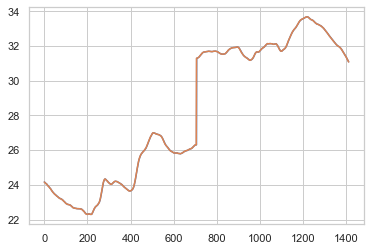

In [69]:
km = TimeSeriesKMeans(n_clusters=2, metric="euclidean", max_iter=5, random_state=0)
km.fit(X)
plt.plot(km.cluster_centers_.reshape(X.shape[1], 2))
plt.show()

In [70]:
km.labels_ # 3 5 6 7 8 9 12 13 14 15 16 17

array([0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1], dtype=int64)

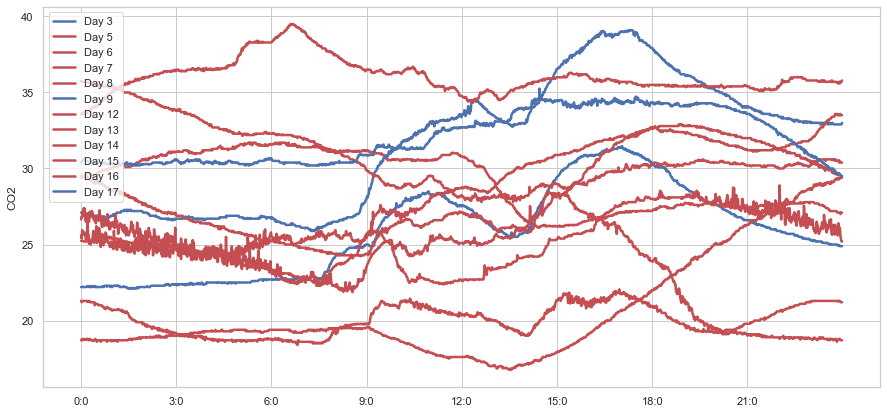

In [71]:
l = 2.5 #line width
plt.figure(figsize = (15, 7))
plt.plot(ts3, color = "b", lw = l)
plt.plot(ts5, color = "r", lw = l)
plt.plot(ts6, color = "r", lw = l) #r
plt.plot(ts7, color = "r", lw = l)
plt.plot(ts8, color = "r", lw = l)
plt.plot(ts9, color = "b", lw = l)
plt.plot(ts12, color = "r", lw = l)
plt.plot(ts13, color = "r", lw = l) #g
plt.plot(ts14, color = "r", lw = l)
plt.plot(ts15, color = "r", lw = l)
plt.plot(ts16, color = "r", lw = l)
plt.plot(ts17, color = "b", lw = l)
plt.legend(["Day 3", 'Day 5', 'Day 6', 'Day 7', 'Day 8', 'Day 9', 'Day 12', 'Day 13', 'Day 14', 'Day 15', 'Day 16', 'Day 17'])
plt.xticks(range(0, 1440, 180))
plt.ylabel('CO2')
plt.show()

In [72]:
inertia2 = km.inertia_ # per essere confrontato con gli altri andrebbe trasformato
inertia2

16631.82113470086

### Dati originali K = 3

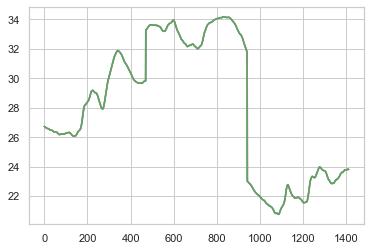

In [73]:
km = TimeSeriesKMeans(n_clusters=3, metric="euclidean", max_iter=5, random_state=0)
km.fit(X)
plt.plot(km.cluster_centers_.reshape(X.shape[1], 3))
plt.show()

In [74]:
km.labels_ # 3 5 6 7 8 9 12 13 14 15 16 17

array([0, 2, 2, 2, 0, 0, 2, 0, 1, 1, 0, 1], dtype=int64)

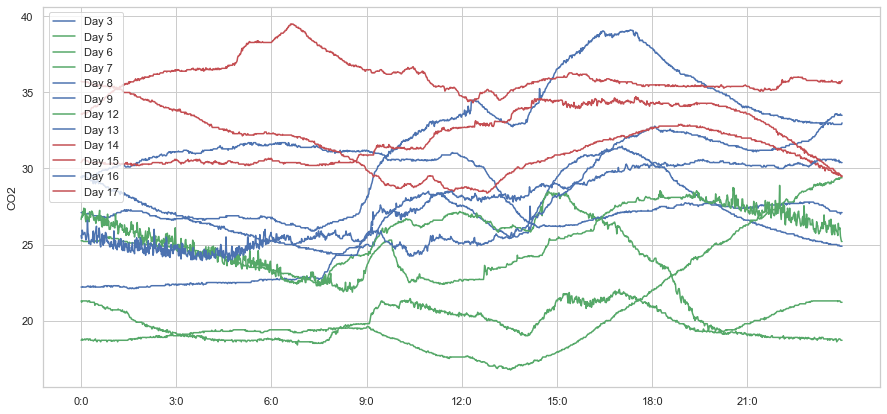

In [75]:
plt.figure(figsize = (15, 7))
plt.plot(ts3, color = "b")
plt.plot(ts5, color = "g")
plt.plot(ts6, color = "g")
plt.plot(ts7, color = "g")
plt.plot(ts8, color = "b")
plt.plot(ts9, color = "b")
plt.plot(ts12, color = "g")
plt.plot(ts13, color = "b")
plt.plot(ts14, color = "r")
plt.plot(ts15, color = "r")
plt.plot(ts16, color = "b")
plt.plot(ts17, color = "r") # same cluster as red ts
plt.legend(["Day 3", 'Day 5', 'Day 6', 'Day 7', 'Day 8', 'Day 9', 'Day 12', 'Day 13', 'Day 14', 'Day 15', 'Day 16', 'Day 17'])
plt.xticks(range(0, 1440, 180))
plt.ylabel('CO2')
plt.show()

In [76]:
inertia3 = km.inertia_
inertia3

11876.781016740444

### Dati normalizzati K = 3

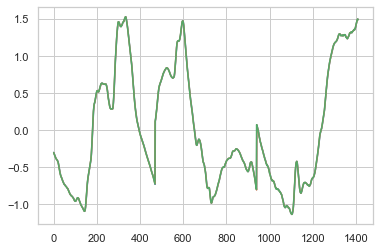

In [77]:
km = TimeSeriesKMeans(n_clusters=3, metric="euclidean", max_iter=5, random_state=0)
km.fit(X_res_nr)
plt.plot(km.cluster_centers_.reshape(X_res_nr.shape[1], 3))
plt.show()

In [78]:
km.labels_ # 3 5 6 7 8 9 12 13 14 15 16 17

array([0, 0, 0, 2, 1, 0, 2, 2, 1, 1, 2, 0], dtype=int64)

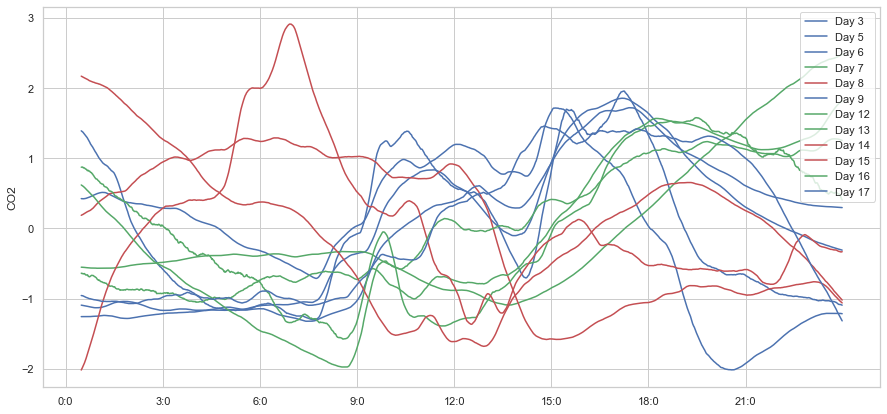

In [79]:
plt.figure(figsize = (15, 7))
plt.plot(ts3_res_nr, color = "b")
plt.plot(ts5_res_nr, color = "b")
plt.plot(ts6_res_nr, color = "b")
plt.plot(ts7_res_nr, color = "g")
plt.plot(ts8_res_nr, color = "r")
plt.plot(ts9_res_nr, color = "b")
plt.plot(ts12_res_nr, color = "g")
plt.plot(ts13_res_nr, color = "g")
plt.plot(ts14_res_nr, color = "r")
plt.plot(ts15_res_nr, color = "r")
plt.plot(ts16_res_nr, color = "g")
plt.plot(ts17_res_nr, color = "b") # same cluster as red ts
plt.legend(["Day 3", 'Day 5', 'Day 6', 'Day 7', 'Day 8', 'Day 9', 'Day 12', 'Day 13', 'Day 14', 'Day 15', 'Day 16', 'Day 17'])
plt.xticks(range(0, 1440, 180))
plt.ylabel('CO2')
plt.show()

In [80]:
inertia_res3 = km.inertia_
inertia_res3

480.0203600665448

In [81]:
print("inertia k=2:                                    ", inertia2) # andrebbe trasformato per renderlo comparabile
print("inertia k=3:                                    ", inertia3)
print("inertia with trandfotmation and noise reduction:", inertia_res3)

inertia k=2:                                     16631.82113470086
inertia k=3:                                     11876.781016740444
inertia with trandfotmation and noise reduction: 480.0203600665448


In [82]:
print((inertia2 - X.mean()) / X.std())
print((inertia3 - X.mean()) / X.std())

3161.294143289079
2255.9736092695885


## Clustering con DTW

- proviamo diverso numero di k (migliore k = 3)
- con dati senza trasformazione K = 2
- con dati senza trasformazione K = 2

### Dati Originali K = 2

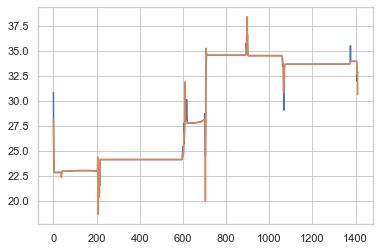

In [83]:
km_dtw = TimeSeriesKMeans(n_clusters=2, metric="dtw", max_iter=5, random_state=0)
km_dtw.fit(X)

plt.plot(km_dtw.cluster_centers_.reshape(X.shape[1], 2))
plt.show()

In [84]:
km_dtw.labels_ # 3 5 6 7 8 9 12 13 14 15 16 17

array([0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1], dtype=int64)

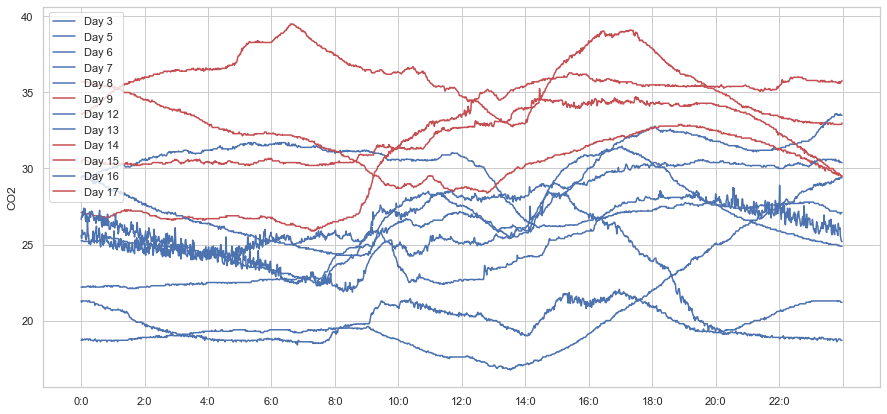

In [85]:
plt.figure(figsize = (15, 7))
plt.plot(ts3, color = "b")
plt.plot(ts5, color = "b")
plt.plot(ts6, color = "b")
plt.plot(ts7, color = "b") #weekend
plt.plot(ts8, color = "b") # weekend
plt.plot(ts9, color = "r")
plt.plot(ts12, color = "b")
plt.plot(ts13, color = "b") 
plt.plot(ts14, color = "r") # weekend
plt.plot(ts15, color = "r") # weekend
plt.plot(ts16, color = "b")
plt.plot(ts17, color = "r") # same cluster as red ts
plt.legend(["Day 3", 'Day 5', 'Day 6', 'Day 7', 'Day 8', 'Day 9', 'Day 12', 'Day 13', 'Day 14', 'Day 15', 'Day 16', 'Day 17'])
plt.xticks(range(0, 1441, 120))
plt.ylabel('CO2')
plt.show()

In [86]:
inertia2 = km_dtw.inertia_
inertia2

3267.099634242535

### Dati originali K = 3

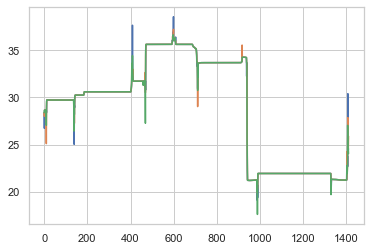

In [87]:
km_dtw = TimeSeriesKMeans(n_clusters=3, metric="dtw", max_iter=5, random_state=0)
km_dtw.fit(X)

plt.plot(km_dtw.cluster_centers_.reshape(X.shape[1], 3))
plt.show()

In [88]:
km_dtw.labels_

array([2, 2, 2, 2, 0, 0, 2, 0, 1, 1, 0, 0], dtype=int64)

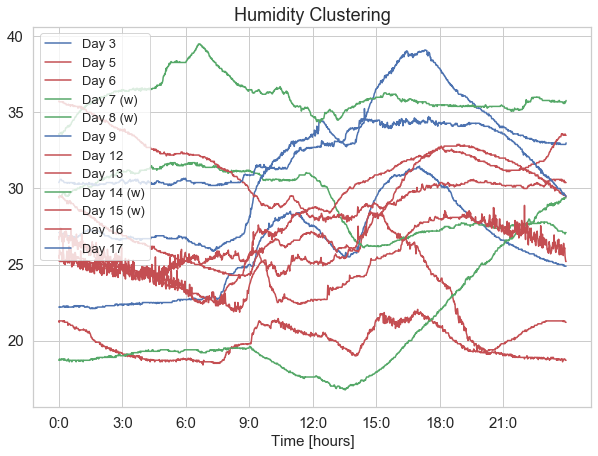

In [109]:
f=15
plt.figure(figsize = (10, 7))
plt.plot(ts3, color = "b")
plt.plot(ts5, color = "r")
plt.plot(ts6, color = "r")
plt.plot(ts7, color = "g") #weekend
plt.plot(ts8, color = "g") # weekend
plt.plot(ts9, color = "b")
plt.plot(ts12, color = "r")
plt.plot(ts13, color = "r") 
plt.plot(ts14, color = "g") # weekend
plt.plot(ts15, color = "r") # weekend
plt.plot(ts16, color = "r")
plt.plot(ts17, color = "b") # same cluster as red ts
plt.legend(["Day 3", 'Day 5', 'Day 6', 'Day 7 (w)', 'Day 8 (w)', 'Day 9', 'Day 12', 'Day 13', 'Day 14 (w)', 'Day 15 (w)', 'Day 16', 'Day 17'], fontsize=f-2)
plt.title("Humidity Clustering", fontsize = f+3)
plt.xticks(range(0, 1440, 180), fontsize = f)
plt.yticks(fontsize=f)
plt.xlabel('Time [hours]', fontsize=f)
plt.show()

In [90]:
inertia3 = km_dtw.inertia_
inertia3

1038.7028630171692

In [91]:
print("inertia k=2:", inertia2) # andrebbe trasformato per renderlo comparabile
print("inertia k=3:", inertia3)

inertia k=2: 3267.099634242535
inertia k=3: 1038.7028630171692


## Feature Based Clustering

- con dati senza trasformazione K = 2
- con dati senza trasformazione K = 3

In [92]:
F = [list(calculate_features(x).values())[:-2] for x in X] # features dei dati originali

In [93]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(F)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

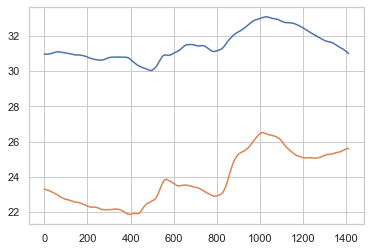

In [94]:
for i in range(2):
    plt.plot(np.mean(X[np.where(kmeans.labels_ == i)[0]], axis=0))
plt.show()

### Dati senza trasformazione

In [95]:
kmeans.labels_

array([1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0])

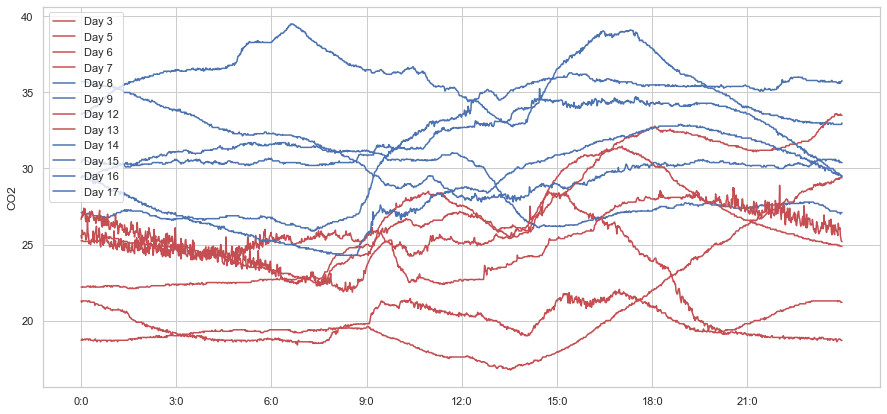

In [96]:
plt.figure(figsize = (15, 7))
plt.plot(ts3, color = "r")
plt.plot(ts5, color = "r")
plt.plot(ts6, color = "r")
plt.plot(ts7, color = "r") #weekend
plt.plot(ts8, color = "b") # weekend
plt.plot(ts9, color = "b")
plt.plot(ts12, color = "r")
plt.plot(ts13, color = "r") 
plt.plot(ts14, color = "b") # weekend
plt.plot(ts15, color = "b") # weekend
plt.plot(ts16, color = "b")
plt.plot(ts17, color = "b")
plt.legend(["Day 3", 'Day 5', 'Day 6', 'Day 7', 'Day 8', 'Day 9', 'Day 12', 'Day 13', 'Day 14', 'Day 15', 'Day 16', 'Day 17'])
plt.xticks(range(0, 1440, 180))
plt.ylabel('CO2')
plt.show()

In [97]:
inertia2 = kmeans.inertia_
inertia2

1473.4562232045007

### Dati originali K = 3

In [98]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(F)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [99]:
kmeans.labels_

array([1, 1, 1, 1, 2, 2, 1, 1, 0, 2, 2, 2])

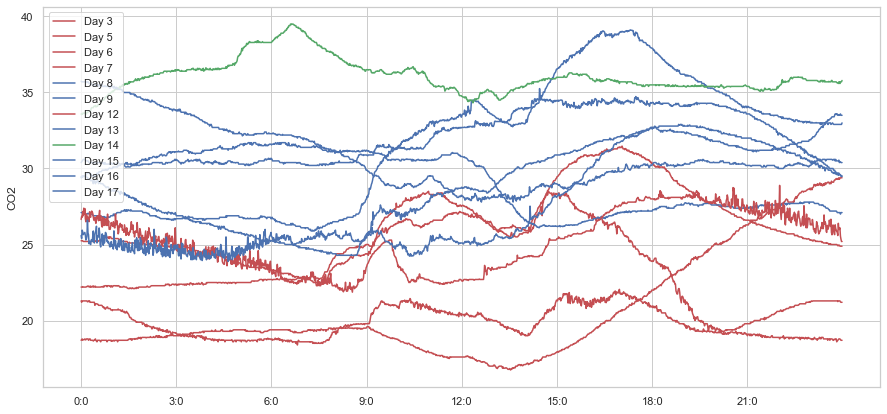

In [100]:
plt.figure(figsize = (15, 7))
plt.plot(ts3, color = "r")
plt.plot(ts5, color = "r")
plt.plot(ts6, color = "r")
plt.plot(ts7, color = "r") #weekend
plt.plot(ts8, color = "b") # weekend
plt.plot(ts9, color = "b")
plt.plot(ts12, color = "r")
plt.plot(ts13, color = "b") 
plt.plot(ts14, color = "g") # weekend
plt.plot(ts15, color = "b") # weekend
plt.plot(ts16, color = "b")
plt.plot(ts17, color = "b")
plt.legend(["Day 3", 'Day 5', 'Day 6', 'Day 7', 'Day 8', 'Day 9', 'Day 12', 'Day 13', 'Day 14', 'Day 15', 'Day 16', 'Day 17'])
plt.xticks(range(0, 1440, 180))
plt.ylabel('CO2')
plt.show()

In [101]:
inertia3 = kmeans.inertia_
inertia3

981.4841389857529

In [102]:
print("inertia k=2:", inertia2) # andrebbe trasformato per renderlo comparabile
print("inertia k=3:", inertia3)

inertia k=2: 1473.4562232045007
inertia k=3: 981.4841389857529


## Compression based clustering

- con dati senza trasformazione
- con dati trasformati
- con dati trasformati e noise reduction

In [103]:
def cdm_dist(x, y):
    x_str = (' '.join([str(v) for v in x.ravel()])).encode('utf-8')
    y_str = (' '.join([str(v) for v in y.ravel()])).encode('utf-8')
    return len(zlib.compress(x_str + y_str)) / (len(zlib.compress(x_str)) + len(zlib.compress(y_str)))

In [104]:
M = pairwise_distances(X.reshape(X.shape[0], X.shape[1]), metric=cdm_dist) # X.reshape() crea un array di 12 righe e 1411 colonne
M_res = pairwise_distances(X_res.reshape(X_res.shape[0], X_res.shape[1]), metric=cdm_dist)
M_res_nr = pairwise_distances(X_res_nr.reshape(X_res_nr.shape[0], X_res_nr.shape[1]), metric=cdm_dist)

In [105]:
m

NameError: name 'm' is not defined

### Dati senza trasformazione

In [ ]:
# stampo come array la matrice delle distanze (M). Cerchiamo poi un valore di epsilon che separi al meglio core, border e outliers
plt.plot(sorted(M.ravel()))
plt.plot(1, color = 'red')
plt.show()

eps = 0.999

In [ ]:
dbscan = DBSCAN(eps=0.999, min_samples=5, metric='precomputed')
dbscan.fit(M)

In [ ]:
pippo = dbscan.labels_
pippo

In [ ]:
plt.figure(figsize = (15, 7))
plt.plot(ts3, color = "r")
plt.plot(ts5, color = "b")
plt.plot(ts6, color = "b")
plt.plot(ts7, color = "b") #weekend
plt.plot(ts8, color = "b") # weekend
plt.plot(ts9, color = "r")
plt.plot(ts12, color = "b")
plt.plot(ts13, color = "b") 
plt.plot(ts14, color = "b") # weekend
plt.plot(ts15, color = "r") # weekend
plt.plot(ts16, color = "r")
plt.plot(ts17, color = "r")
plt.legend(["Day 3", 'Day 5', 'Day 6', 'Day 7', 'Day 8', 'Day 9', 'Day 12', 'Day 13', 'Day 14', 'Day 15', 'Day 16', 'Day 17'])
plt.xticks(range(0, 1440, 180))
plt.ylabel('CO2')
plt.show()

eps = 0.997

In [ ]:
dbscan = DBSCAN(eps=0.997, min_samples=5, metric='precomputed')
dbscan.fit(M)

In [ ]:
pippo = dbscan.labels_
pippo

In [ ]:
plt.figure(figsize = (15, 7))
plt.plot(ts3, color = "black")
plt.plot(ts5, color = "b")
plt.plot(ts6, color = "b")
plt.plot(ts7, color = "r") #weekend
plt.plot(ts8, color = "r") # weekend
plt.plot(ts9, color = "b")
plt.plot(ts12, color = "b")
plt.plot(ts13, color = "b") 
plt.plot(ts14, color = "r") # weekend
plt.plot(ts15, color = "r") # weekend
plt.plot(ts16, color = "g")
plt.plot(ts17, color = "r")
plt.legend(["Day 3", 'Day 5', 'Day 6', 'Day 7', 'Day 8', 'Day 9', 'Day 12', 'Day 13', 'Day 14', 'Day 15', 'Day 16', 'Day 17'])
plt.xticks(range(0, 1440, 180))
plt.ylabel('CO2')
plt.show()

eps = 0.996

In [ ]:
dbscan = DBSCAN(eps=0.996, min_samples=5, metric='precomputed')
dbscan.fit(M)

In [ ]:
pippo = dbscan.labels_
pippo

In [ ]:
plt.figure(figsize = (15, 7))
plt.plot(ts3, color = "black")
plt.plot(ts5, color = "b")
plt.plot(ts6, color = "b")
plt.plot(ts7, color = "r") #weekend
plt.plot(ts8, color = "r") # weekend
plt.plot(ts9, color = "b")
plt.plot(ts12, color = "b")
plt.plot(ts13, color = "b") 
plt.plot(ts14, color = "r") # weekend
plt.plot(ts15, color = "r") # weekend
plt.plot(ts16, color = "r")
plt.plot(ts17, color = "r")
plt.legend(["Day 3", 'Day 5', 'Day 6', 'Day 7', 'Day 8', 'Day 9', 'Day 12', 'Day 13', 'Day 14', 'Day 15', 'Day 16', 'Day 17'])
plt.xticks(range(0, 1440, 180))
plt.ylabel('CO2')
plt.show()

In [ ]:
for i in range(len(X_res)):
    if pippo[i] == 0: # core
        #continue
        plt.plot(X_res[i], color='r')
    if pippo[i] == -1: #noise
        #continue
        plt.plot(X_res[i], color = 'b')
plt.show()

### Dati con trasformazione

In [ ]:
plt.plot(sorted(M_res.ravel()))
plt.show()

In [ ]:
dbscan = DBSCAN(eps=0.999, min_samples=5, metric='precomputed')
dbscan.fit(M)

In [ ]:
pippo = dbscan.labels_
pippo

In [ ]:
plt.figure(figsize = (15, 7))
plt.plot(ts3, color = "b")
plt.plot(ts5, color = "b")
plt.plot(ts6, color = "b")
plt.plot(ts7, color = "b") #weekend
plt.plot(ts8, color = "r") # weekend
plt.plot(ts9, color = "b")
plt.plot(ts12, color = "b")
plt.plot(ts13, color = "b") 
plt.plot(ts14, color = "r") # weekend
plt.plot(ts15, color = "r") # weekend
plt.plot(ts16, color = "b")
plt.plot(ts17, color = "r")
plt.legend(["Day 3", 'Day 5', 'Day 6', 'Day 7', 'Day 8', 'Day 9', 'Day 12', 'Day 13', 'Day 14', 'Day 15', 'Day 16', 'Day 17'])
plt.xticks(range(0, 1440, 180))
plt.ylabel('CO2')
plt.show()

### Dati con trasfomazione e noise reduction

In [ ]:
plt.plot(sorted(M_res_nr.ravel()))
plt.show()

In [ ]:
dbscan = DBSCAN(eps=0.999, min_samples=5, metric='precomputed')
dbscan.fit(M)

In [ ]:
pippo = dbscan.labels_
pippo

In [ ]:
plt.figure(figsize = (15, 7))
plt.plot(ts3, color = "b")
plt.plot(ts5, color = "b")
plt.plot(ts6, color = "b")
plt.plot(ts7, color = "b") #weekend
plt.plot(ts8, color = "r") # weekend
plt.plot(ts9, color = "b")
plt.plot(ts12, color = "b")
plt.plot(ts13, color = "b") 
plt.plot(ts14,  color = "r") # weekend
plt.plot(ts15, color = "r") # weekend
plt.plot(ts16, color = "b")
plt.plot(ts17, color = "r")
plt.legend(["Day 3", 'Day 5', 'Day 6', 'Day 7', 'Day 8', 'Day 9', 'Day 12', 'Day 13', 'Day 14', 'Day 15', 'Day 16', 'Day 17'])
plt.xticks(range(0, 1440, 180))
plt.ylabel('CO2')
plt.show()